In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('../ride_sharing_data.csv')

In [3]:
X = data.drop('Demand', axis=1)
y = data['Demand']

In [4]:
numerical_features = ['Price', 'Distance', 'Base_Price', 'Weather_Multiplier']
categorical_features = ['Time_of_Day', 'Weather']

all_features_in_data = list(X.columns)
numerical_features = [col for col in numerical_features if col in all_features_in_data]
categorical_features = [col for col in categorical_features if col in all_features_in_data]

numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [5]:
print("Training final demand model on ALL data...")
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
final_model.fit(X, y)
print("Model training complete.")

Training final demand model on ALL data...
Model training complete.


In [6]:
def find_optimal_price(ride_details, model, min_price=15, max_price=150, steps=100):
    """
    Simulates a range of prices to find the one that maximizes revenue.
    
    ride_details: A dictionary with all features EXCEPT 'Price'.
    """
    
    # 1. Create a "test" DataFrame with our ride details
    test_data = pd.DataFrame([ride_details])
    
    # 2. Create a range of prices to test
    price_range = np.linspace(min_price, max_price, steps)
    
    # 3. Build a DataFrame for all price points
    # We copy the ride details for each potential price
    simulation_df = pd.concat([test_data] * len(price_range), ignore_index=True)
    simulation_df['Price'] = price_range
    
    # 4. Predict demand for ALL prices at once
    predicted_demand = model.predict(simulation_df)
    
    # 5. Calculate revenue for each price
    simulation_df['Predicted_Demand'] = predicted_demand
    simulation_df['Revenue'] = simulation_df['Price'] * simulation_df['Predicted_Demand']
    
    # 6. Find the optimal price
    # We clip demand at 0, as negative demand makes no sense
    simulation_df['Predicted_Demand'] = simulation_df['Predicted_Demand'].clip(lower=0)
    simulation_df['Revenue'] = simulation_df['Price'] * simulation_df['Predicted_Demand']
    
    optimal_row = simulation_df.loc[simulation_df['Revenue'].idxmax()]
    
    return optimal_row, simulation_df

In [7]:
print("\n--- Running Optimization Simulation ---")

# Let's create a sample ride
# (using the first row of our data as an example)
sample_ride_request = X.iloc[0].to_dict()
print(f"Sample Ride Request (Original): {sample_ride_request}")

# CRITICAL: We must remove the 'Price' from the sample
# because our function will test its own prices.
if 'Price' in sample_ride_request:
    del sample_ride_request['Price']

print(f"\nOptimizing for ride: {sample_ride_request}")


--- Running Optimization Simulation ---
Sample Ride Request (Original): {'Distance': 8.116262258099887, 'Time_of_Day': 'Evening', 'Weather': 'Snowy', 'Base_Price': 12, 'Weather_Multiplier': 2.0, 'Price': 305.27}

Optimizing for ride: {'Distance': 8.116262258099887, 'Time_of_Day': 'Evening', 'Weather': 'Snowy', 'Base_Price': 12, 'Weather_Multiplier': 2.0}


In [8]:
optimal_result, full_simulation = find_optimal_price(sample_ride_request, final_model)

print("\n--- OPTIMAL PRICE FOUND ---")
print(f"  Optimal Price: ${optimal_result['Price']:.2f}")
print(f"  Predicted Demand at this price: {optimal_result['Predicted_Demand']:.2f} rides")
print(f"  Maximized Revenue: ${optimal_result['Revenue']:.2f}")


--- OPTIMAL PRICE FOUND ---
  Optimal Price: $150.00
  Predicted Demand at this price: 1.61 rides
  Maximized Revenue: $240.99


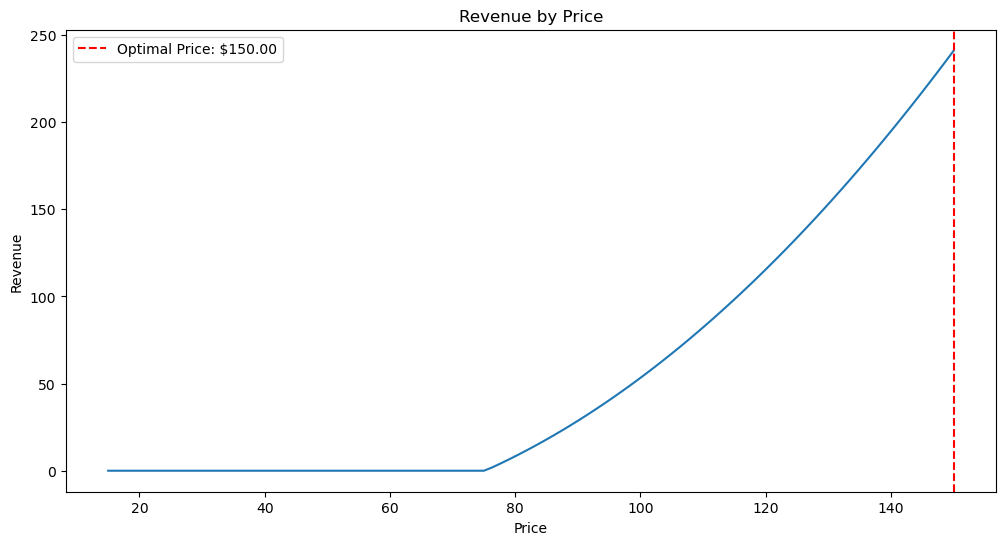

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=full_simulation, x='Price', y='Revenue')
plt.title('Revenue by Price')
plt.axvline(x=optimal_result['Price'], color='red', linestyle='--', label=f'Optimal Price: ${optimal_result["Price"]:.2f}')
plt.legend()
plt.show()